In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
siglist = [ (700,300,), (1000,450), (1200,500) ]
module = fc.eightb.preselection.ranked_quadh
get_fn = lambda module, mx, my: getattr(module, f"NMSSM_XYY_YToHH_8b_MX_{mx}_MY_{my}")
signal = ObjIter([ Tree(get_fn(module, mx, my), use_gen=False) for mx, my in siglist])

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


In [4]:
bkg = ObjIter([ Tree(module.QCD_B_List, use_gen=False),Tree(module.TTJets, use_gen=False) ])

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


In [5]:
def ak_rank(array, axis=-1, descending=False):
  argsort = ak.argsort( (-1)**descending * array, axis=axis )
  return ak.argsort(argsort, axis=axis)

In [6]:
t8btag = CollectionFilter('jet', 'jet', filter=lambda t: ak_rank(t.jet_btag, descending=True) < 8)

signal = signal.apply(t8btag)
bkg = bkg.apply(t8btag)

In [7]:
signals = [ signal, signal.copy(), signal.copy() ]
bkgs = [ bkg, bkg.copy(), bkg.copy() ]

In [8]:
modules = dict(
  dr_points="/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/weaver/models/quadh_ranker/20220823-143139_ranger_lr0.0047_batch64_m10_dr/",
  dpt_points="/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/weaver/models/quadh_ranker/20220823-143633_ranger_lr0.0047_batch64_m10_dpt/"
)

modules = dict(
  absp4="/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/weaver/models/quadh_ranker/20220823-163909_ranger_lr0.0047_batch64_m10_absp4/",
  relpt="/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/weaver/models/quadh_ranker/20220823-190216_ranger_lr0.0047_batch64_m10_relpt/",
  relp4="/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/weaver/models/quadh_ranker/20220823-163918_ranger_lr0.0047_batch64_m10_relp4/"
)

for model, signal, bkg in zip(modules.values(), signals, bkgs):
  (signal+bkg).apply(lambda t : eightb.load_quadh(t, model), report=True)

100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


In [21]:
use_bkg = any((any(bkg) for bkg in bkgs))
def compare_modules(var, bkg=use_bkg, figax=None, **kwargs):
  n = len(signals[0])+1 if bkg else len(signals[0])
  if figax is None:
    figax = study.get_figax(n, dim=(-1,n))
  fig, axs = figax
  
  label = list(modules.keys())

  for i, samples in enumerate(zip(*signals)):
    study.quick(
      list(samples), legend=True,
      label=label,
      h_linestyle=[':','--','-'],
      varlist=[var],
      text=(0.0,1.0, samples[0].sample),
      text_style=dict(ha='left',va='bottom'),
      figax=(fig,axs.flat[i]),
      **kwargs,
    )

  if not bkg: return

  study.quick_region(
    *bkgs, legend=True,
    h_color=['grey']*3,
    label=label,
    h_linestyle=[':','--','-'],
    varlist=[var],
    text=(0.0,1.0,'MC-Bkg'),
    text_style=dict(ha='left',va='bottom'),
    figax=(fig,axs.flat[-1]),
    **kwargs,
  )
def compare_samples(var, bkg=use_bkg, figax=None, efficiency=True, **kwargs):
  if figax is None:
    figax = study.get_figax(len(modules), dim=(-1,len(modules)))
  fig, axs = figax

  samples = signals

  if bkg:
    samples = [ sample+bkg for sample, bkg in zip(samples, bkgs)]
  label=list(modules.keys())
  h_linestyle=[':','--','-']


  for i, sample in enumerate(samples):
    study.quick(
      sample, legend=True, stacked=True,
      varlist=[var],
      h_linestyle=[h_linestyle[i]]*sample.is_signal.npy.sum(),
      text=(0.0,1.0, label[i]),
      text_style=dict(ha='left',va='bottom'),
      efficiency=efficiency,
      figax=(fig,axs.flat[i]),
      **kwargs,
    )

In [10]:
dout = "comparing_rankers"

100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


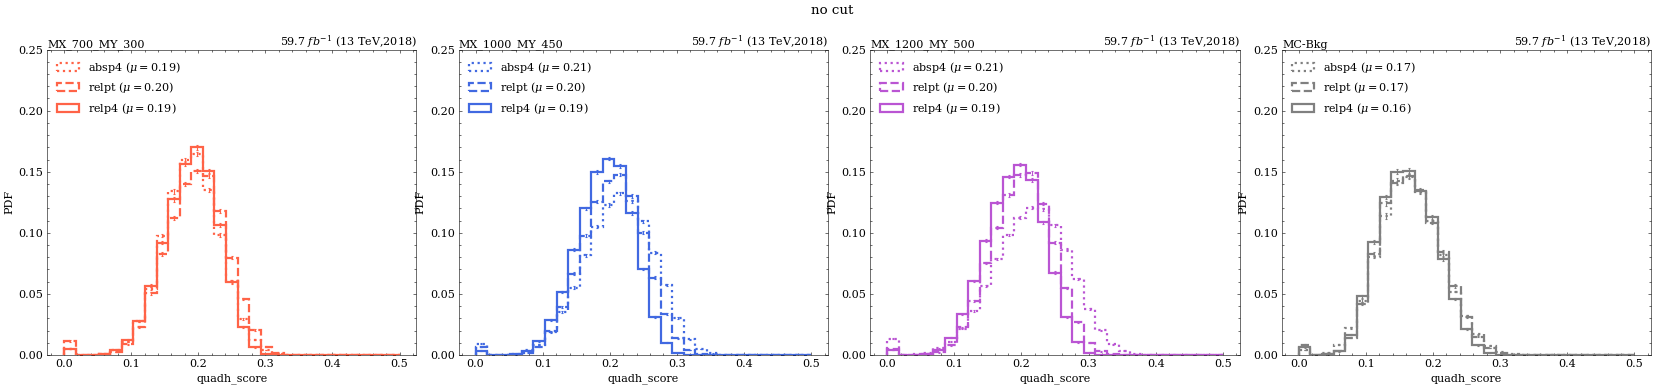

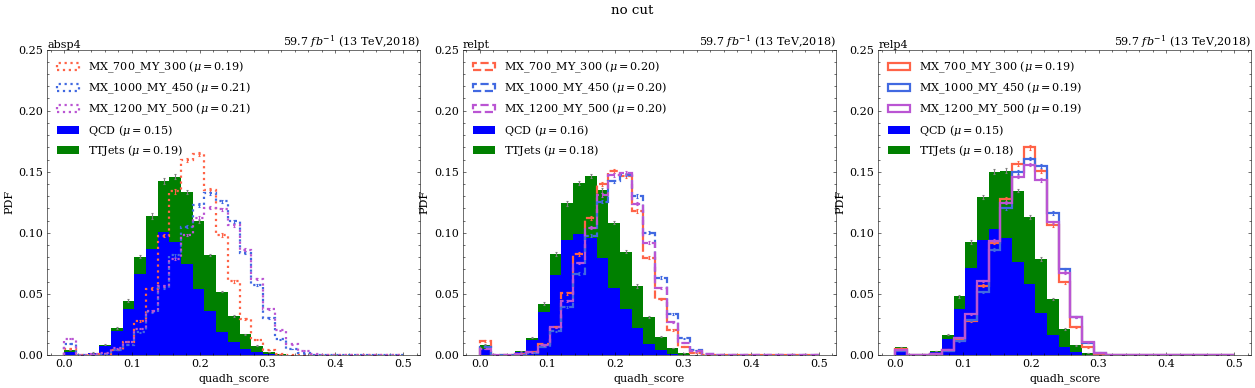

In [11]:
varinfo.quadh_score = dict(bins=(0,0.5,30))
compare_modules('quadh_score', efficiency=True, ylim=(0,0.25), h_label_stat="$\mu={stats.mean:0.2f}$", title="no cut", saveas=f'{dout}/ranker_quadh_score')
compare_samples('quadh_score', ylim=(0,0.25), h_label_stat="$\mu={stats.mean:0.2f}$", title="no cut", saveas=f'{dout}/sample_quadh_score')

In [26]:
combinations

<function utils.selectUtils.combinations(nitems, ks)>

In [12]:
def nfound_paired_h(t):
  nhiggs = ak.sum(t.dijet_signalId>-1,axis=-1)
  t.extend(nfound_paired_h=nhiggs)
for signal in signals:
  signal.apply(nfound_paired_h)

100%|██████████| 1/1 [00:00<00:00, 24.49it/s]


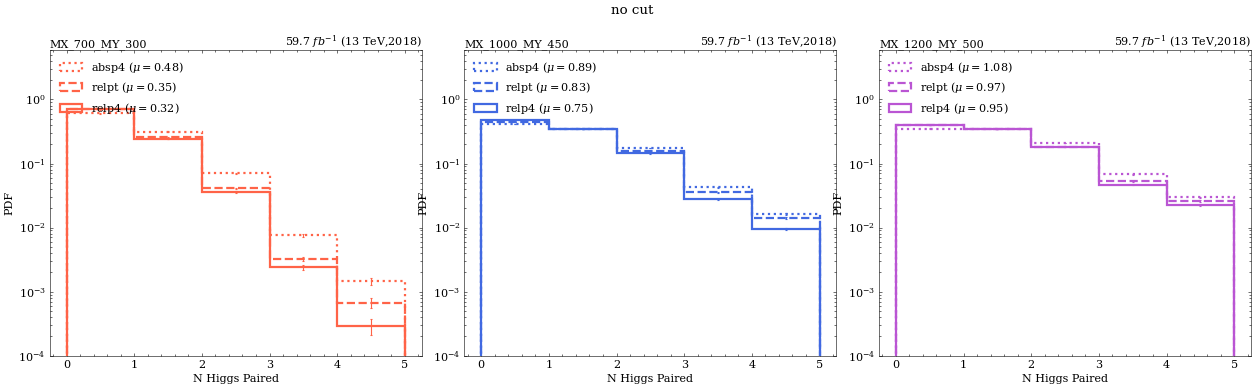

In [13]:
varinfo.nfound_paired_h = dict(xlabel='N Higgs Paired', bins=None)
compare_modules('nfound_paired_h', bkg=False, efficiency=True, 
log=True, ylim=(1e-4,6e0), h_label_stat="$\mu={stats.mean:0.2f}$", title="no cut",
saveas=f'{dout}/ranker_pairing_eff')

100%|██████████| 1/1 [00:00<00:00, 21.30it/s]


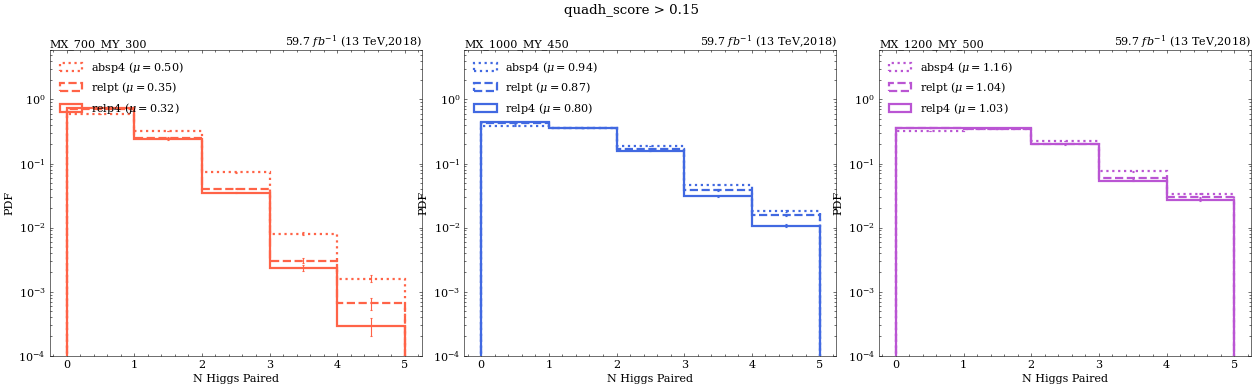

In [14]:
compare_modules('nfound_paired_h', bkg=False, efficiency=True,
 log=True, ylim=(1e-4,6e0), masks=lambda t : t.quadh_score > 0.15, 
 title='quadh_score > 0.15',  h_label_stat="$\mu={stats.mean:0.2f}$",
 saveas=f'{dout}/ranker_paired_eff_score15')

100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


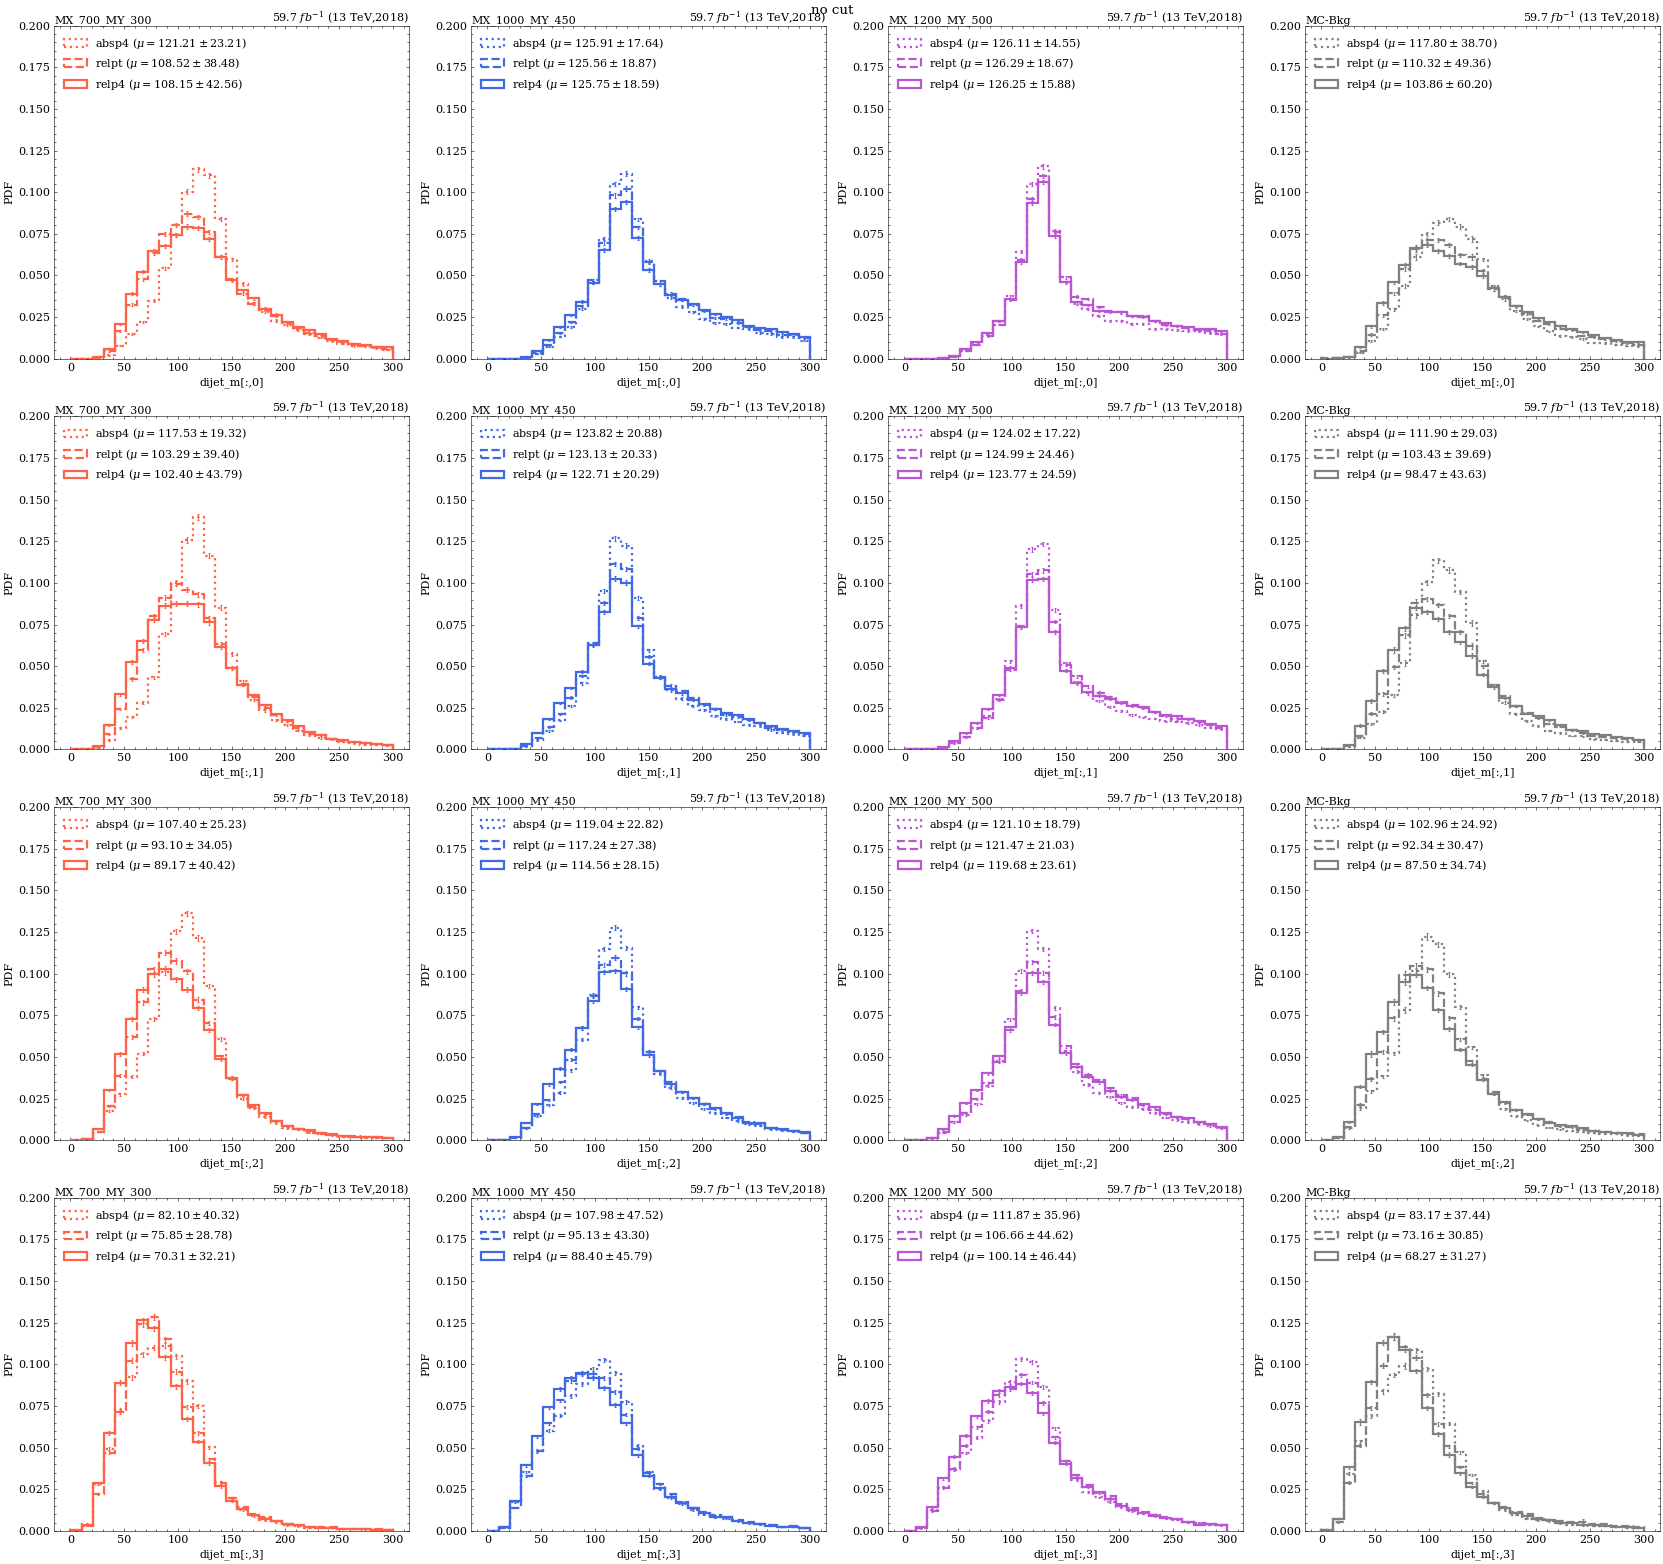

In [15]:
varinfo.dijet_m = dict(bins=(0,300,30))
fig,axs = study.get_figax(4*4, dim=(4,4))
for i in range(4):
  compare_modules(f"dijet_m[:,{i}]", efficiency=True, ylim=(0,0.2), h_label_stat="$\mu={fit.mu:0.2f}\pm{fit.sigma:0.2f}$", h_fit='gaussian', h_fit_peak=True,
   title="no cut", figax=(fig, axs[i]))
study.save_fig(fig,'',f'{dout}/ranker_dijet_m')


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


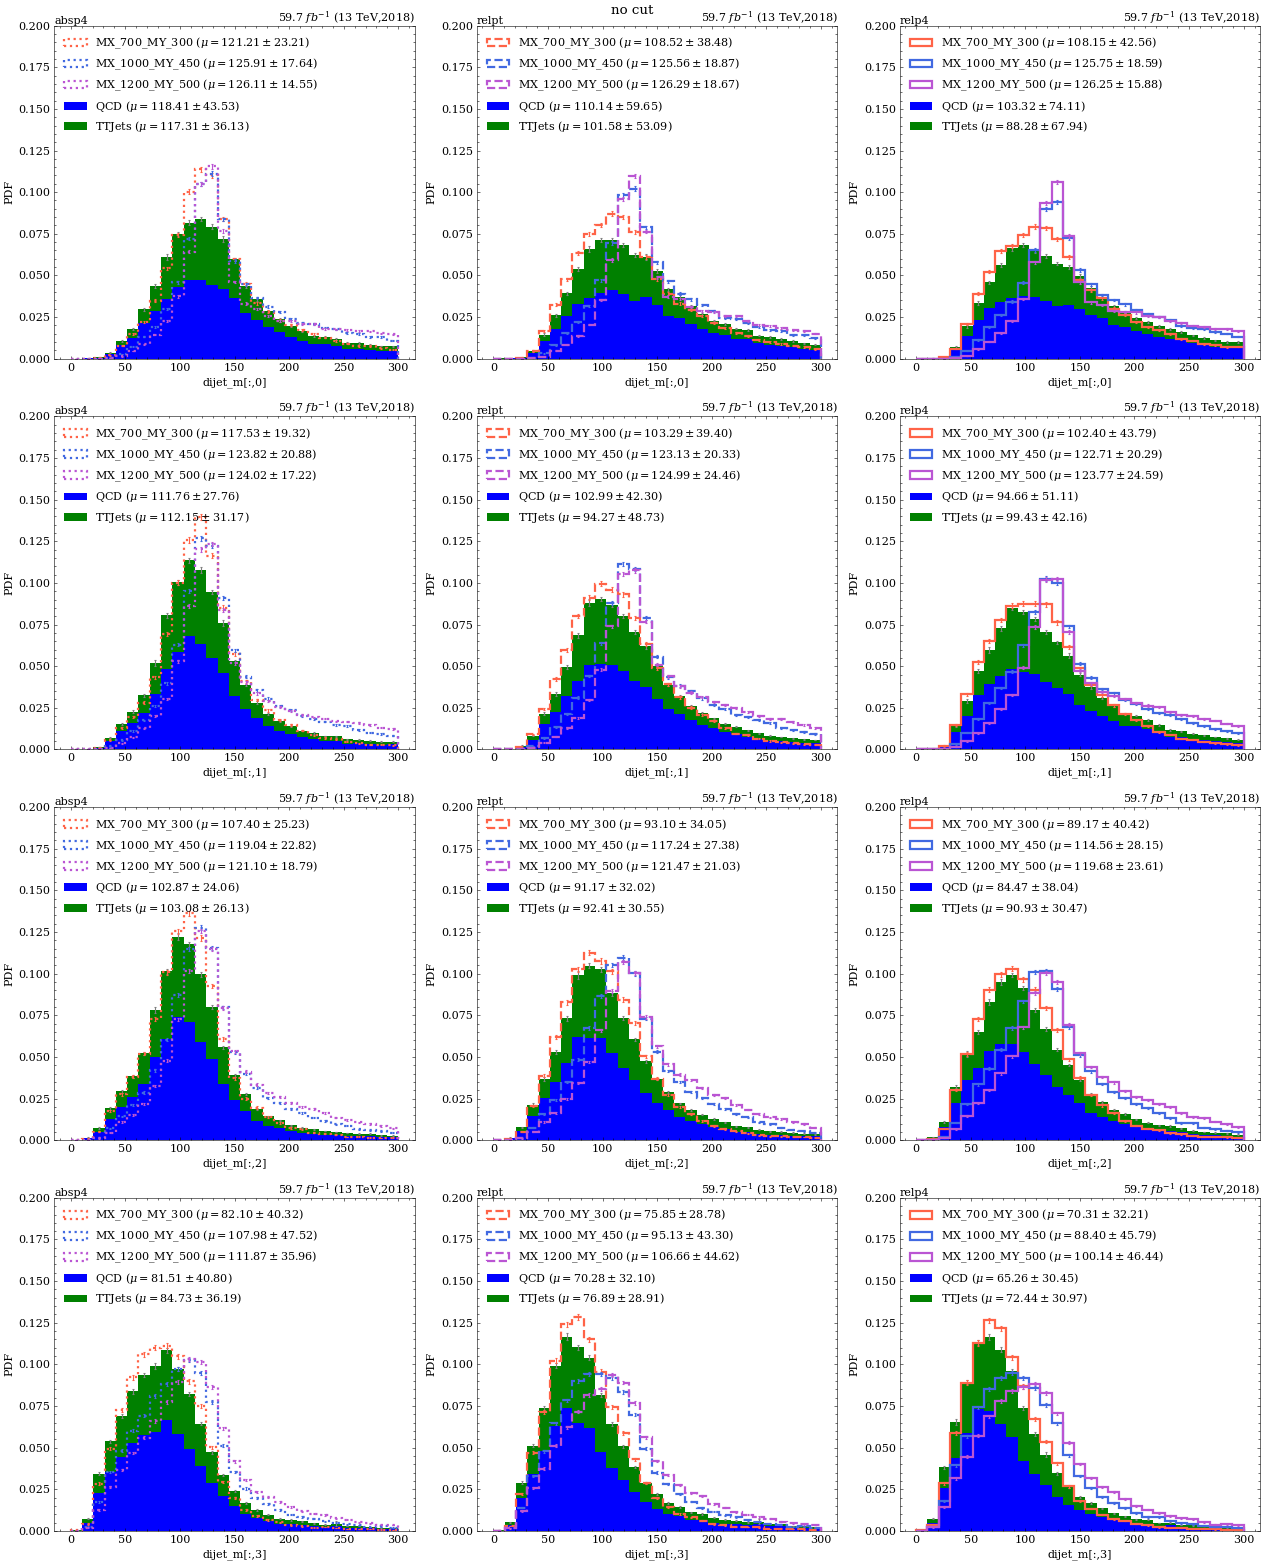

In [16]:
varinfo.dijet_m = dict(bins=(0,300,30))

fig,axs = study.get_figax(4*3, dim=(4,3))
for i in range(4):
  compare_samples(f"dijet_m[:,{i}]", ylim=(0,0.2),h_label_stat="$\mu={fit.mu:0.2f}\pm{fit.sigma:0.2f}$", h_fit='gaussian', h_fit_peak=True,
   title="no cut", figax=(fig, axs[i]))
study.save_fig(fig,'',f'{dout}/sample_dijet_m')


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


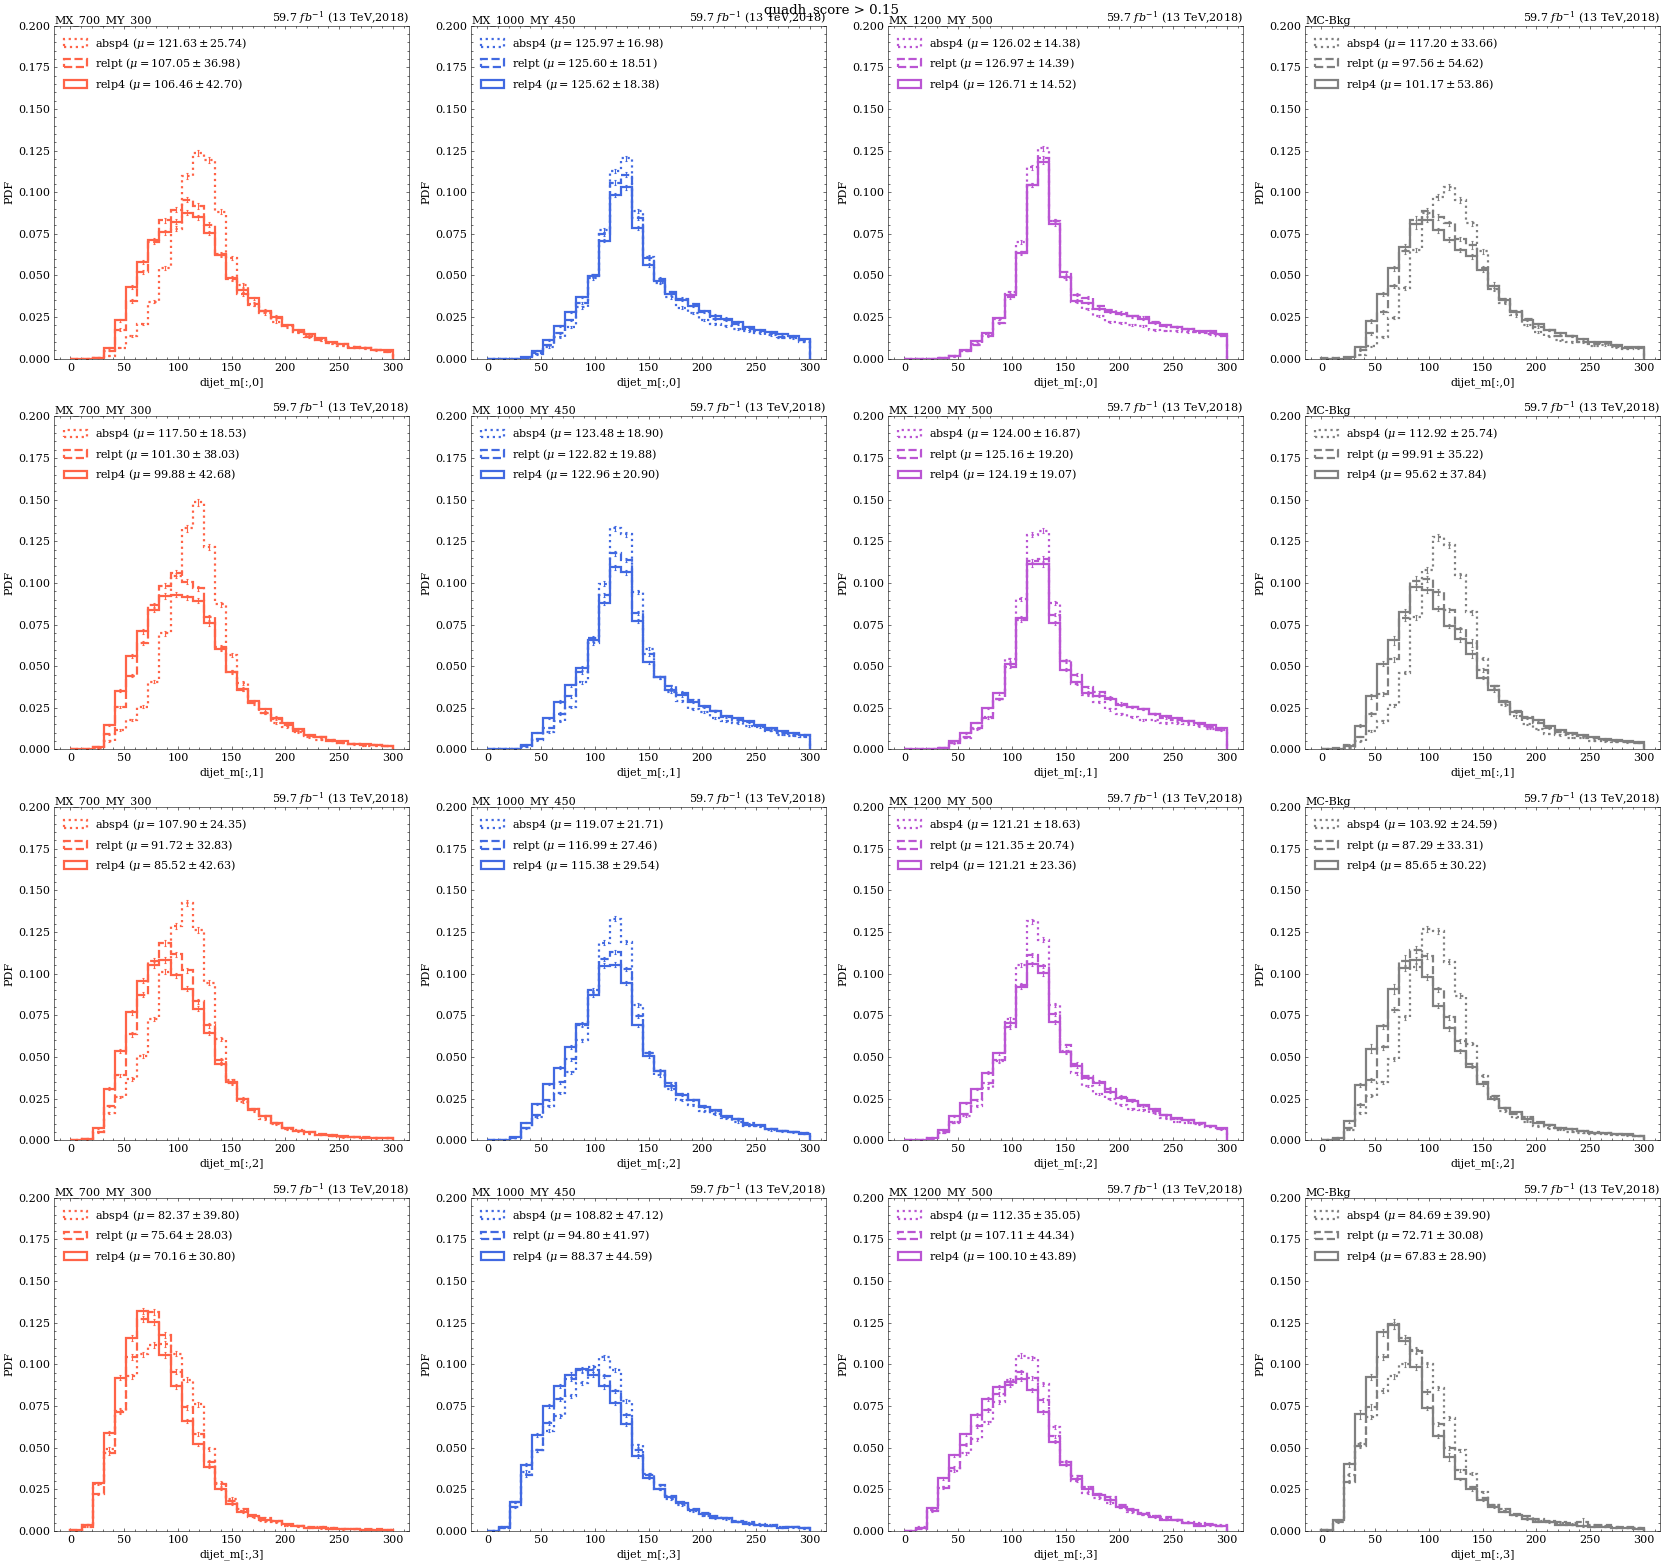

In [17]:
varinfo.dijet_m = dict(bins=(0,300,30))
fig,axs = study.get_figax(4*4, dim=(4,4))
for i in range(4):
  compare_modules(f"dijet_m[:,{i}]", efficiency=True, ylim=(0,0.2), 
  h_label_stat="$\mu={fit.mu:0.2f}\pm{fit.sigma:0.2f}$", h_fit='gaussian', h_fit_peak=True,
  masks=lambda t : t.quadh_score > 0.15, title='quadh_score > 0.15', figax=(fig, axs[i]))
study.save_fig(fig,'',f'{dout}/ranker_dijet_m_score15')


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


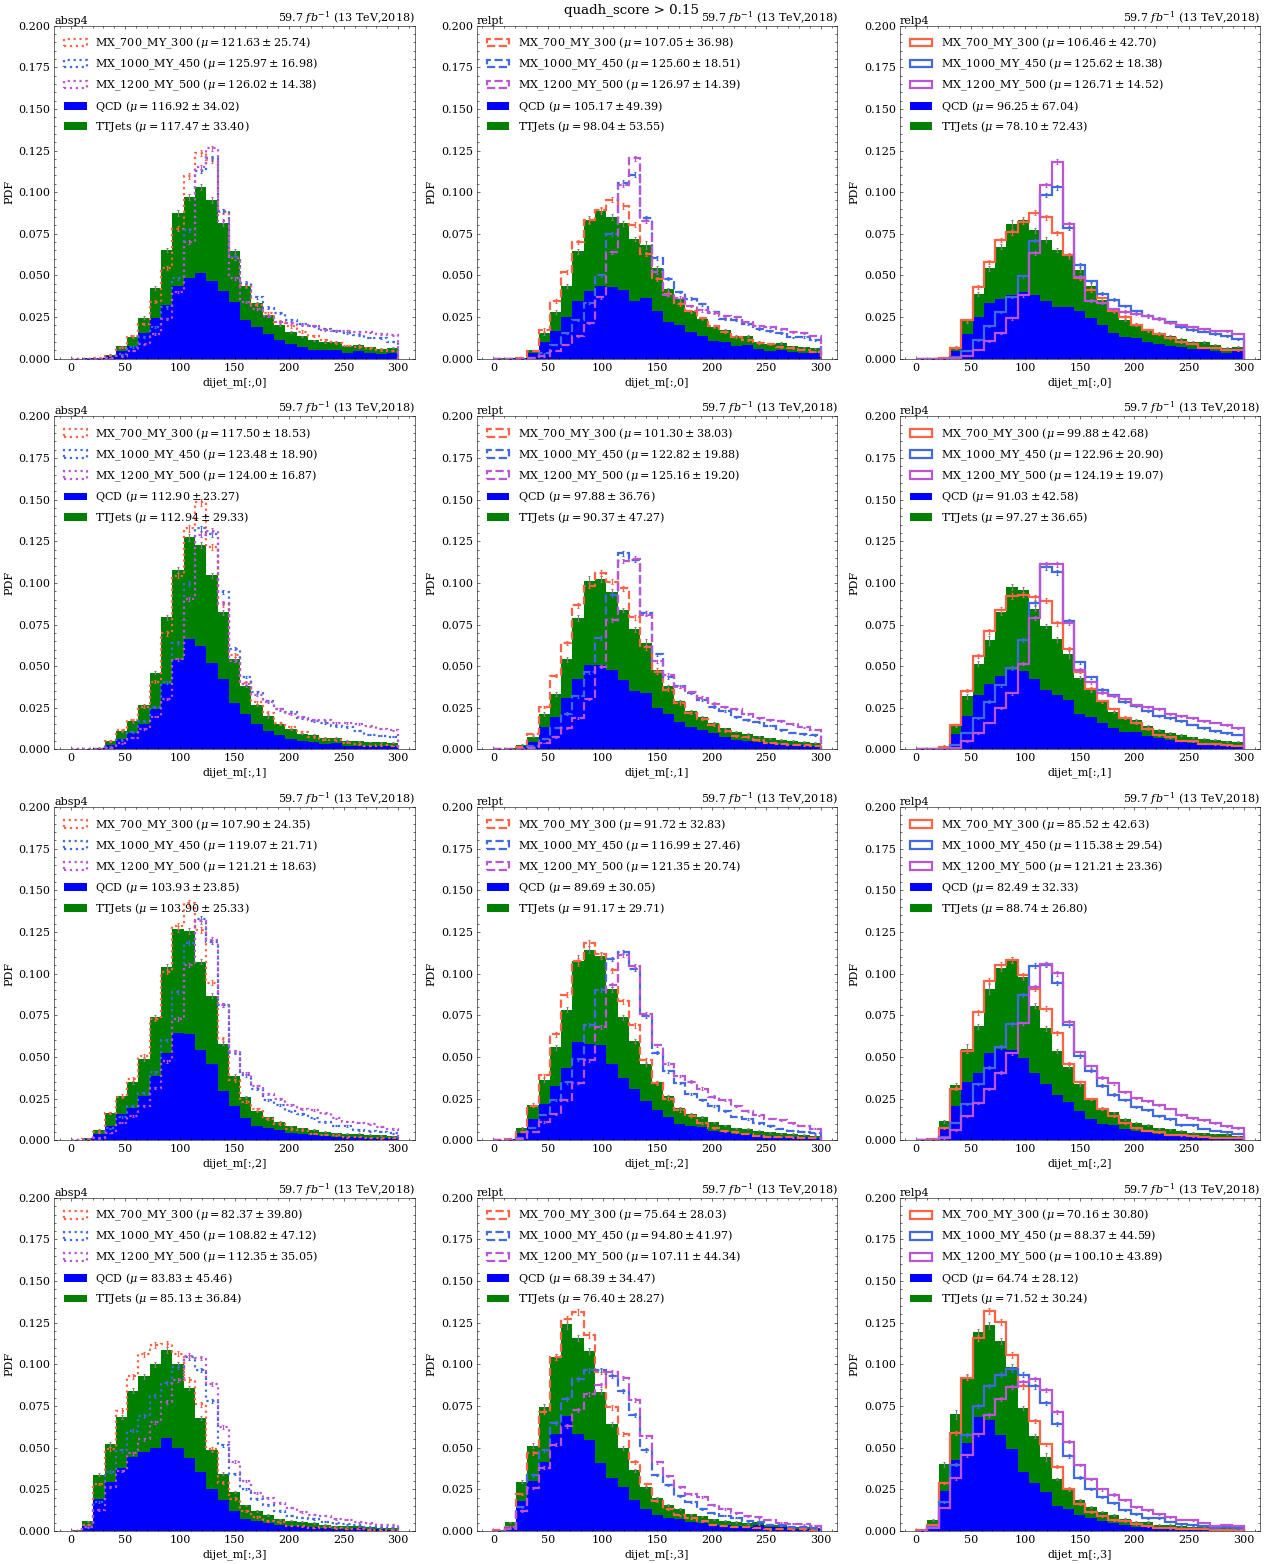

In [18]:
fig,axs = study.get_figax(4*3, dim=(4,3))
for i in range(4):
  compare_samples(f"dijet_m[:,{i}]", ylim=(0,0.2), 
  h_label_stat="$\mu={fit.mu:0.2f}\pm{fit.sigma:0.2f}$", h_fit='gaussian', h_fit_peak=True,
  masks=lambda t : t.quadh_score > 0.15, title='quadh_score > 0.15', 
  figax=(fig, axs[i])
  )
fig.tight_layout()
study.save_fig(fig,'',f'{dout}/sample_dijet_m_score15')
